In [ ]:
!pip install geopandas==0.14.4
!pip install matplotlib==3.9.2
!pip install osmnx==1.9.4
!pip install contextily==1.6.1

In [6]:
import osmnx
import geopandas
import matplotlib
import contextily

Gemeindegrenzen von Ramsen holen:

<Axes: >

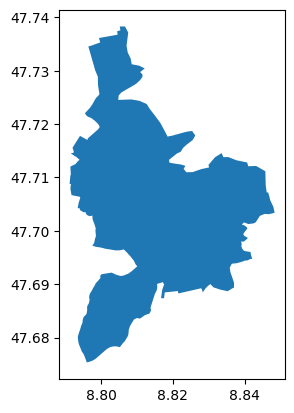

In [28]:
ramsen_grenze = osmnx.geocode_to_gdf("Ramsen, Switzerland")
ramsen_grenze.plot()

Spielplätze Ramsen holen:

In [7]:
spielplaetze_in_ramsen = osmnx.features_from_place(query="Ramsen, Switzerland", tags={"leisure": "playground"})
spielplaetze_in_ramsen

nodes  \
element_type osmid                                                           
way          1127340227  [10307408520, 10307408519, 10307408518, 103074...   
             1225393718  [11363837562, 11363837561, 11363837560, 113638...   

                            leisure  \
element_type osmid                    
way          1127340227  playground   
             1225393718  playground   

                                                                  geometry  
element_type osmid                                                          
way          1127340227  POLYGON ((8.81620 47.70941, 8.81605 47.70940, ...  
             1225393718  POLYGON ((8.81276 47.70726, 8.81261 47.70730, ...

Kartenvorschau der Spielplätze in Ramsen:

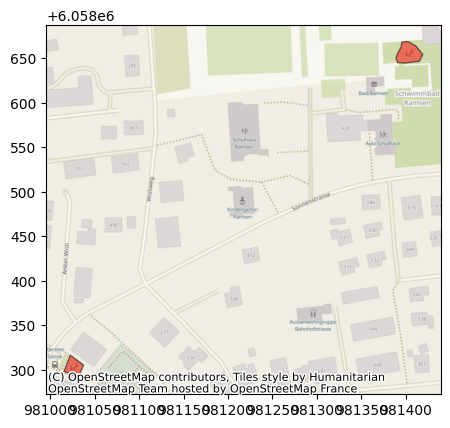

In [38]:
spielplaetze_in_ramsen_map = spielplaetze_in_ramsen.to_crs(epsg=3857)
spielplaetze_in_ramsen_plot = spielplaetze_in_ramsen_map.plot(alpha=0.5, edgecolor='k', color='red')
contextily.add_basemap(spielplaetze_in_ramsen_plot)

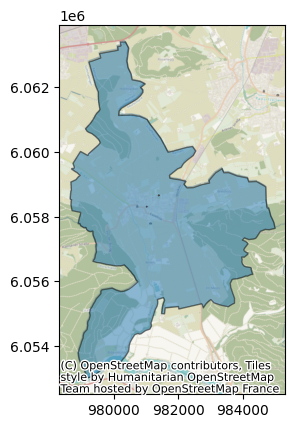

In [37]:
ramsen_grenze_map = ramsen_grenze.to_crs(epsg=3857)
ramsen_grenze_plot = ramsen_grenze_map.plot(alpha=0.5, edgecolor='k')

spielplaetze_in_ramsen_map = spielplaetze_in_ramsen.to_crs(epsg=3857)
spielplaetze_in_ramsen_plot = spielplaetze_in_ramsen_map.plot(ax = ramsen_grenze_plot, alpha=0.5, edgecolor='k', color='red')

contextily.add_basemap(spielplaetze_in_ramsen_plot)

Alle Gebäude in Ramsen:

<Axes: >

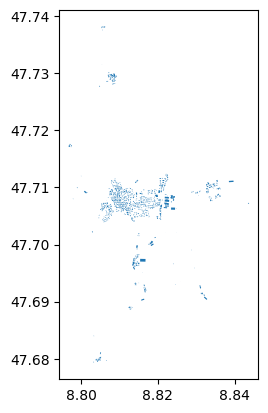

In [40]:
gebaeude_in_ramsen = osmnx.features_from_place(query="Ramsen, Switzerland", tags={"building": True})
gebaeude_in_ramsen.plot()

In [3]:
wege_in_ramsen = osmnx.graph_from_place("Ramsen, Switzerland")
wege_in_ramsen